<a href="https://colab.research.google.com/github/daisy-dotcom/ms_pacman/blob/main/ms_pacman_sac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# run this cell once per Colab session
!apt update
!apt-get install xvfb x11-utils
!python -m pip install --upgrade swig
!python -m pip install --upgrade pyvirtualdisplay moviepy
!python -m pip install --upgrade gymnasium[accept-rom-license,atari,box2d,classic_control,mujoco,toy_text]
!python -m pip install torchinfo

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,031 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,593 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,448 kB]
Get:13 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [

In [3]:
# import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from pyvirtualdisplay import Display
import moviepy.editor as mpy
from torchinfo import summary
import ale_py

gym.register_envs(ale_py)
# create random number generator
rng = np.random.default_rng()

# create and start virtual display
display = Display(backend='xvfb')
display.start()

In [ ]:
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")
env.observation_space

Box(0, 255, (128,), uint8)

In [4]:
torch.get_default_device()

device(type='cpu')

In [5]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.set_default_device(torch.device(device))

torch.cuda.is_available()

True

In [6]:
torch.get_default_device()

device(type='cuda', index=0)

In [ ]:
#seed = 4
#random.seed(seed)
#np.random.seed(seed)
#torch.manual_seed(seed)

In [7]:
# SAC Q-network for approximating action-value function
class SACQNetwork(nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()
        # create network layers
        layers = nn.ModuleList()

        # input layers
        layers.append(nn.Linear(in_channels, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())


        # output layers
        # outputs a 1D tensor of size 1 with the Q value
        layers.append(nn.Linear(hidden_sizes[-1], output_size))


        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select loss function and optimizer
        # note: original paper uses modified MSE loss and RMSprop
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(),
                                          lr=learning_rate)

        # initialise the weights according to dueling network architecture
        self.net.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # convert input to torch format
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float)

        # return output of Q-network
        return self.net(x)

    def update(self, state, action, targets):
        # update network weights for a minibatch of inputs and targets:
        self.optimizer.zero_grad()
        outputs = self.forward(state)
        #print(outputs.shape)
        #print(targets.shape)
        outputs = outputs.gather(1, action.long())
        loss = self.criterion(outputs, targets)
        loss.backward()
        self.optimizer.step()

    def copy_from(self, qnetwork):
        # copy weights from another Q-network
        self.net.load_state_dict(qnetwork.net.state_dict())

In [8]:
class TwinQNetwork(nn.Module):
    def __init__(self, in_channels, hidden_sizes, output_size, learning_rate):
        super().__init__()
        # create twin network
        self.q1 = SACQNetwork(in_channels, hidden_sizes, output_size, learning_rate)
        self.q2 = SACQNetwork(in_channels, hidden_sizes, output_size, learning_rate)

    def forward(self, x):
        # return output of Q-network for the state + action input
        return self.q1(x), self.q2(x)

    def update(self, inputs, action, targets):
        # update network weights for a minibatch of inputs and targets:
        self.q1.update(inputs, action, targets)
        self.q2.update(inputs, action, targets)

    def copy_from(self, sac_qnetwork):
        # copy weights from another Q-network
        self.q1.copy_from(sac_qnetwork.q1)
        self.q2.copy_from(sac_qnetwork.q2)

In [9]:
# Policy network for approximating policy function
# source: https://arxiv.org/pdf/1910.07207
class SACPolicyNetwork(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_sizes,
                 output_size,
                 learning_rate):
        super().__init__()
        # create network layers
        layers = nn.ModuleList()

        # input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())

        # output layer (preferences/logits/unnormalised log-probabilities)
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        #layers.append(nn.Softmax(dim=1))

        # combine layers into feed-forward network
        self.net = nn.Sequential(*layers)

        # select optimizer
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate)

        # initialise the weights according to dueling network architecture
        self.net.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # convert input to torch format
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float)
        # return output of policy network
        return self.net(x)

    def get_action_and_log_prob(self, state):
      logits = self.forward(state)
      dist = torch.distributions.Categorical(logits=logits)
      action_probs = dist.probs
      action = dist.sample()
      z = action_probs == 0
      z = z.float() * 1e-8
      log_pi = torch.log(action_probs + z)
      return action, action_probs, log_pi

    def update(self, policy_loss):
        # update network weights for a given transition or trajectory
        self.optimizer.zero_grad()
        #logits = self.net(states)
        #dist = torch.distributions.Categorical(logits=logits)
        #loss = torch.mean(-dist.log_prob(actions)*entropy_coef)
        loss = policy_loss
        loss.backward()
        self.optimizer.step()

In [10]:
from os import stat_result
# source: https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py
class SAC():
    def __init__(self,
                 env,
                 gamma,
                 hidden_sizes=(32, 32),
                 replay_size=10000,
                 minibatch_size=32,
                 actor_learning_rate=0.001,
                 critic_learning_rate=0.005,
                 target_update=20,
                 warmup_target=100,
                 training_ep_per_eval=4,
                 target_entropy_ratio=0.98,
                 optim_time=4):

        # check if the state space has correct type
        #continuous = isinstance(env.observation_space, spaces.Box) and len(env.observation_space.shape) == 1
        #assert continuous, 'Observation space must be continuous with shape (n,)'
        self.state_dims = env.observation_space.shape[0]
        #self.state_dims = env.observation_space.n

        # check if the action space has correct type
        assert isinstance(env.action_space, spaces.Discrete), 'Action space must be discrete'
        self.num_actions = env.action_space.n

        self.online_critic = TwinQNetwork(self.state_dims, hidden_sizes, self.num_actions, critic_learning_rate)
        self.target_critic = TwinQNetwork(self.state_dims, hidden_sizes, self.num_actions, critic_learning_rate)

        self.target_critic.copy_from(self.online_critic)

        # create policy network
        self.actor = SACPolicyNetwork(self.state_dims, hidden_sizes, self.num_actions, actor_learning_rate)

        # replay buffer
        self.replay_buffer = deque(maxlen=replay_size)
        self.minibatch_size = minibatch_size
        self.target_update = target_update
        self.target_update_steps = 0
        self.target_update_idx = 0

        # automatic entropy tuning
        self.target_entropy = target_entropy_ratio * -np.array(-np.log(1.0/self.num_actions), dtype=np.float32)
        self.log_entropy_coef = torch.zeros(1, requires_grad=True)
        self.entropy_optim = torch.optim.Adam([self.log_entropy_coef], lr=actor_learning_rate)
        self.entropy_coef = self.log_entropy_coef.exp()

        self.warmup_target = warmup_target
        self.training_ep_per_eval = training_ep_per_eval
        self.optim_time = optim_time

        self.env = env
        self.gamma = gamma


    def policy(self, state, stochastic=True, eval=False):
        # convert state to torch format
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float)

        # calculate action probabilities
        if not eval:
          logits = self.actor(state).detach()
        else:
          with torch.no_grad():
            logits = self.actor(state).detach()

        dist = torch.distributions.Categorical(logits=logits)
        if stochastic:
            # sample action using action probabilities
            return dist.sample().item()
        else:
            # select action with the highest probability
            # note: we ignore breaking ties randomly (low chance of happening)
            return dist.probs.argmax().item()

    def get_experiences(self):
      batch = rng.choice(len(self.replay_buffer), size=self.minibatch_size, replace=False)
      #print(self.replay_buffer)

      replay_state = np.zeros((self.minibatch_size, self.state_dims))
      replay_action = np.zeros((self.minibatch_size, 1))
      replay_reward = np.zeros((self.minibatch_size, 1))
      replay_next_state = np.zeros((self.minibatch_size, self.state_dims))
      is_failure = np.zeros((self.minibatch_size, 1))

      i = 0
      for row in batch:
        replay_state[i] = self.replay_buffer[row][0]
        replay_action[i] = self.replay_buffer[row][1]
        replay_reward[i] = self.replay_buffer[row][2]
        replay_next_state[i] = self.replay_buffer[row][3]
        is_failure[i] = self.replay_buffer[row][4]
        i += 1

      #np_replay_buffer = np.array(self.replay_buffer)
      #replay_state, replay_action, replay_reward, replay_next_state, is_failure = list(zip(*np_replay_buffer[batch]))

      replay_state = torch.tensor(replay_state, dtype=torch.float)
      replay_action = torch.tensor(replay_action, dtype=torch.float)
      replay_reward = torch.tensor(replay_reward, dtype=torch.float)
      replay_next_state = torch.tensor(replay_next_state, dtype=torch.float)
      is_failure = torch.tensor(is_failure, dtype=torch.float)

      return replay_state, replay_action, replay_reward, replay_next_state, is_failure


    def update(self):
      # unpack trajectory
      #batch = rng.choice(len(self.replay_buffer), size=self.minibatch_size, replace=False)
      #t_replay_buffer = torch.Tensor(self.replay_buffer)
      #if len(self.replay_buffer) >= self.minibatch_size:

      replay_state, replay_action, replay_reward, replay_next_state, is_failure = self.get_experiences()

      with torch.no_grad():
        action, next_action_probs, next_log_pi = self.actor.get_action_and_log_prob(replay_next_state)
        #dist = torch.distributions.Categorical(logits=logits)
        #next_log_pi = dist.logits
        #next_action_probs = torch.exp(next_log_pi)

        next_target_q1, next_target_q2 = self.target_critic(replay_next_state)
        min_next_q = torch.min(next_target_q1, next_target_q2)

        min_next_target_q = next_action_probs * (min_next_q - self.entropy_coef * next_log_pi)
        min_next_target_q = min_next_target_q.sum(dim=1, keepdim=True)

        next_q = replay_reward + (1.0 - is_failure) * self.gamma * min_next_target_q

      # update online critic
      self.online_critic.update(replay_next_state, replay_action, next_q)

      # calculate policy loss - actor
      # get q-value estimates of visited states
      q1, q2 = self.online_critic(replay_state)
      min_q = torch.min(q1, q2)

      action, action_probs, log_pi = self.actor.get_action_and_log_prob(replay_state)
      #dist = torch.distributions.Categorical(logits=logits)
      #log_pi = dist.logits
      #action_probs = torch.exp(log_pi)

      policy_loss = action_probs * ((self.entropy_coef * log_pi)  - min_q)
      policy_loss = policy_loss.sum(dim=1).mean()

      # entropy tuning
      entropy_loss = -(self.log_entropy_coef * (log_pi + self.target_entropy).detach()).mean()

      # update actor
      self.actor.update(policy_loss)

      # update entropy
      self.entropy_optim.zero_grad()
      entropy_loss.backward()
      self.entropy_optim.step()
      self.entropy_coef = self.log_entropy_coef.exp().detach()

      # update target critic network
      #self.target_update_idx += 1
      if self.target_update_steps % self.target_update == 0:
        self.target_critic.copy_from(self.online_critic)


    def train(self, max_episodes, stop_criterion, criterion_episodes):
        # train the agent for a number of episodes
        self.num_steps = 0

        episode_rewards = []
        training_rewards = []
        for episode in range(max_episodes):
            steps = 0
            state, _ = self.env.reset()

            # convert state to torch format
            #state = torch.tensor(state, dtype=torch.float)
            terminated = False
            truncated = False


            rewards = []
            trajectory = []
            eval_ep = episode % self.training_ep_per_eval == 0
            if eval_ep:
              episode_rewards.append(0)
            else:
              training_rewards.append(0)

            # generate trajectory
            while not (terminated or truncated):
                # select action by following policy

                action = self.policy(state, stochastic=not eval_ep, eval=eval_ep)

                # send the action to the environment
                next_state, reward, terminated, truncated, _  = self.env.step(action)
                rewards.append(reward)
                if eval_ep:
                  episode_rewards[-1] += reward
                else:
                  training_rewards[-1] += reward

                is_failure = terminated and not truncated

                # add transition to trajectory
                #experience = np.concatenate(())
                if not eval_ep:
                  self.replay_buffer.append((state,
                                            action,
                                            reward,
                                            next_state,
                                            float(is_failure)))

                  #self.update()

                # convert next state to torch format
                #next_state = torch.tensor(next_state, dtype=torch.float)

                state = next_state
                self.num_steps += 1
                steps += 1

                # update policy & critic networks
                done_warmup = self.num_steps > self.warmup_target
                enough_exp = len(self.replay_buffer) >= self.minibatch_size
                optim_time = self.num_steps % self.optim_time == 0
                if (done_warmup and enough_exp and optim_time):
                  self.update()

            if eval_ep:
              print(f'\rEpisode {episode+1} done: steps = {self.num_steps}, '
                    f'rewards = {np.sum(rewards)}', end='')

            else:
              print(f'\r Training Episode {episode+1} done: steps = {self.num_steps}, '
                    f'rewards = {np.sum(rewards)}', end='')

            if episode >= criterion_episodes-1 and stop_criterion(episode_rewards[-criterion_episodes:]):
                print(f'\nStopping criterion satisfied after {episode} episodes')
                break

        # plot rewards received during training
        plt.figure(dpi=100)
        plt.plot(range(1, len(episode_rewards)+1), episode_rewards, label=f'Rewards')

        plt.xlabel('Eval Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

        plt.figure(dpi=100)
        plt.plot(range(1, len(training_rewards)+1), training_rewards, label=f'Rewards')

        plt.xlabel('Training Episodes')
        plt.ylabel('Rewards per episode')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    def evaluate_agent(self, num_episodes=1):
      eval_rewards = []
      steps = 0
      for episode in range(num_episodes):
        state, _ = self.env.reset()

        terminated = False
        truncated = False
        eval_rewards.append(0)
        # generate trajectory
        while not (terminated or truncated):
            # select action by following a greedy policy
            with torch.no_grad():
              action = self.policy(state, stochastic=False)

            # send the action to the environment
            next_state, reward, terminated, truncated, _  = self.env.step(action)
            eval_rewards[-1] += reward
            state = next_state
            steps += 1

      return np.mean(eval_rewards), steps


    def copy_from(self, policynet):
       # copy weights from another Q-network
       self.net.copy_from(policynet)

    def save(self, path):
        # save network weights to a file
        torch.save(self.actor.state_dict(), path)

    def load(self, path):
        # load network weights from a file
        self.actor.load_state_dict(torch.load(path))

 Training Episode 10 done: steps = 816, rewards = -84.38694665165848

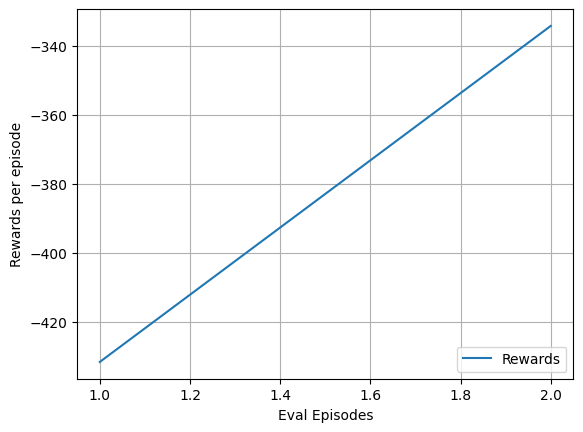

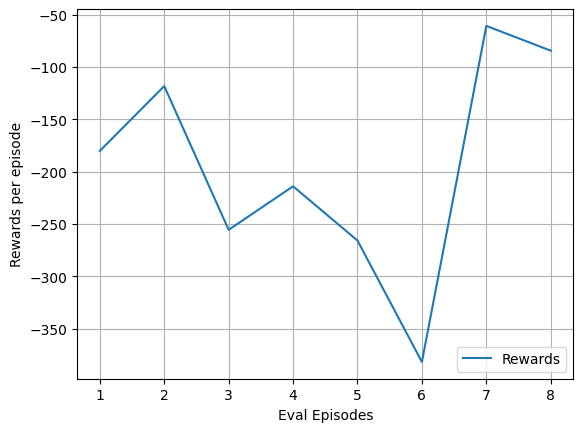

In [ ]:
# create the acrobot environment
env = gym.make('LunarLander-v3', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64)
actor_learning_rate = 0.001
critic_learning_rate = 0.005
#epsilon = 0.01
#rep_omega = 0.2
replay_size = 100000
minibatch_size = 64
target_update = 20000
training_ep_per_eval = 5
warmup_target = 3000
target_entropy_ratio = 0.9

max_episodes = 10
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio)


agent.train(max_episodes, lambda x : min(x) >= -150, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state, stochastic=False)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: -386.70038660979156


 Training Episode 3000 done: steps = 2191466, rewards = 210.0

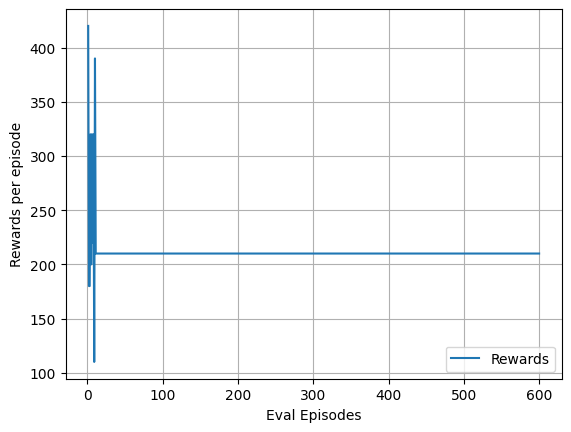

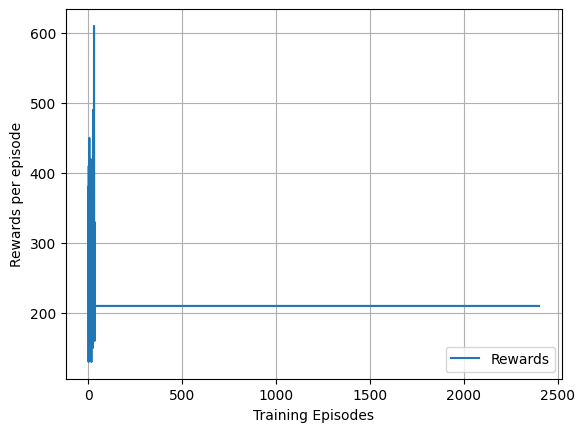

In [ ]:
# create the acrobot environment
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (1024, 1024, 1024)
actor_learning_rate = 0.001
critic_learning_rate = 0.005
replay_size = 100000
minibatch_size = 64
target_update = 8000
training_ep_per_eval = 5
warmup_target = 20000
target_entropy_ratio = 0.9
optim_time = 4

max_episodes = 3000
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state, stochastic=False)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Reward: 210.0


In [ ]:
# create the acrobot environment
env = gym.make('ALE/MsPacman-ram-v5', render_mode="rgb_array_list")

gamma = 0.99
hidden_sizes = (64, 64, 64)
actor_learning_rate = 0.001
critic_learning_rate = 0.005
replay_size = 100000
minibatch_size = 64
target_update = 8000
training_ep_per_eval = 5
warmup_target = 20000
target_entropy_ratio = 0.9
optim_time = 4

max_episodes = 3000
max_steps = 18000
criterion_episodes = 5

agent = SAC(env,
            gamma=gamma,
            hidden_sizes=hidden_sizes,
            actor_learning_rate=actor_learning_rate,
            critic_learning_rate=critic_learning_rate,
            replay_size=replay_size,
            minibatch_size=minibatch_size,
            target_update=target_update,
            training_ep_per_eval=training_ep_per_eval,
            warmup_target = warmup_target,
            target_entropy_ratio=target_entropy_ratio)


agent.train(max_episodes, lambda x : min(x) >= 1000, criterion_episodes)


 Training Episode 240 done: steps = 119564, rewards = 70.0

In [ ]:
# visualise one episode
state, _ = env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
while not (terminated or truncated or steps > max_steps):
    # take action based on policy
    with torch.no_grad():
      action = agent.policy(state, stochastic=False)

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = env.step(action)
    #print(f'Reward: {reward}')
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')

# store RGB frames for the entire episode
frames = env.render()

# close the environment
env.close()

# create and play video clip using the frames and given fps
clip = mpy.ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

In [ ]:
import os
res_dir = 'drive/MyDrive/Colab Notebooks/Reinforcement Learning/results'
res_path = os.path.join(os.getcwd(),res_dir)
res_path

In [ ]:
agent.save(f"{res_path+'/mspacman.ram.128.sac.pt'}")